This uses data from the UN to determine whether education spending (% of total governmental spending dedicated to education) differs between countries with high vs low human development indices. The HD index was developed by the UN, and takes into account life expectancy, years of schooling, and national income per capita.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels

In [2]:
educate = pd.read_csv('https://raw.githubusercontent.com/antovich/PyPSC290/master/UNEducationSpending.csv')
develop = pd.read_csv('https://raw.githubusercontent.com/antovich/PyPSC290/master/UNHumanDevelopmentIndex.csv')

# merge datasets based on country, only using data that overlaps between datasets
df = pd.merge(left=educate, right=develop, left_on='Reference Area', right_on='Country', how='inner')


In [3]:
# sort by countries' HD index rank
df = df.sort_values('HDI rank')

# get mean for 40 countries with highest HD
highest = df[0:39]
highmean = highest['Observation Value'].mean()

# get mean for 40 countries with lowest HD
lowest = df[len(df)-40:len(df)]
lowmean = lowest['Observation Value'].mean()

#difference between low and high HDI countries
meandiff = lowmean-highmean

print(highmean, lowmean, meandiff)

12.3871397436 16.480137 4.09299725641


In [4]:
#ttest compare highest ranking and lowest ranking HDI countries percent of GNI spend on education
from statsmodels.stats.weightstats import ttest_ind
t, p, dof = ttest_ind(highest['Observation Value'], lowest['Observation Value'],usevar='unequal')
print ('%.5f' %p)

0.00010


Somewhat unexpectedly, countries with lowest HDI rankings spent a greater portion of their GNI on education than higher HDI. Perhaps this is because they have smaller overall budgets, so education takes up a larger portion of the funds.

Instead of the using a t-test, we could shuffle the high and low groups percent GNI data points to create a distribution of possible difference scores. 

In [14]:
# create new 'split' variable to add label for low vs. high HDI rankings
highest['split'] = 'high'
lowest['split'] = 'low'

#new dataframe with low and high HDI ranking countries data
df = pd.concat([highest, lowest])

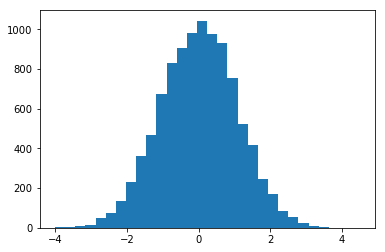

p = 0.00010


In [17]:
# Function to shuffle group labels for two groups numShuffle number of times,
# then take the mean difference between the shuffled groups for each iteration,
# print histogram of mean differences and p-value for proportion of values that are more
# extreme in the sample distribution than in the observed mean difference

# Groups to compare labeled as groupLab1 and groupLab2 in the shuffleCol column of dataframe df
# Data to average stored in dataCol column of dataframe df
# Number of bins to plot in histogram stored in numBins

def shuffleTest(df, dataCol, shuffleCol, groupLab1, groupLab2, numShuffle, numBins):

    # get observed difference between means
    mean1 = df[dataCol][df[shuffleCol] == groupLab1].mean()
    mean2 = df[dataCol][df[shuffleCol] == groupLab2].mean()
    obsDiff = mean1 - mean2
    
    # creates temporary DF for use in the for loop below
    dfTemp = df.copy()
    
    # initiate array for sample means for the for loop below
    sampMean = np.zeros((numShuffle))
    
    # shuffle group labels numShuffle number of times and 
    # find mean diff between groups for each sample, stored in sampMean
    for i in range(numShuffle - 1):
        dfTemp[shuffleCol] = np.random.permutation(dfTemp[shuffleCol])
        sampMean[i] = dfTemp[dataCol][dfTemp[shuffleCol] == groupLab1].mean() - dfTemp[dataCol][dfTemp[shuffleCol] == groupLab2].mean()
    
    # Get nonparametric p-value (proportion of sample mean differences more extreme than the observed mean difference)
    p = sum(abs(sampMean) >= abs(obsDiff))/numShuffle
    
    # plot the frequency of sample mean differences using numBins number of bins
    plt.hist(sampMean, bins = numBins)
    plt.show()
    print('p = %.5f' %p)

shuffleTest(df=df, dataCol='Observation Value', shuffleCol='split', groupLab1='high', groupLab2='low', numShuffle=10000, numBins = 30)

The shuffleTest function returns a similar p-value to the ttest from ttest_ind in statsmodels